In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


selected_columns = ['Policy No',  'Renewal Type', 'Product name ', 'Product name  2', 'biztype', 'Policy End Date', 'Policy Start Date',
                    'Reg no ', 'age', 'MANUFACTURER/Make', 'model', 'variant', 'Fuel Type', 'RTO Location ', 'Before GST Add-on GWP',  
                    'Total OD Premium', 'Total TP Premium', 'gst', 'Total Premium Payable ', 'NCB % Previous Year', 'Vehicle Segment', 
                    'Applicable Discount with NCB', 'New Branch Name  2', 'decline', 'Tie Up', 'state2', 'Cleaned_Insured name', 
                    'CustomerID', 'Policy Status', 'Policy Tenure', 'Customer Tenure', 'New Customers', 
                    'Renewal Rate Status', 'Claim in last year', 'Number of Claims']

data = pd.read_csv('D:\Liberty 2024 Base\Actual_Data_South.csv')
data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[data['Policy Status'].isin(['Renewed', 'Not Renewed'])]


data['Policy Status'] = data['Policy Status'].apply(lambda x: 1 if x == 'Not Renewed' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['Policy Start Date', 'Policy End Date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop date columns after splitting
data = data.drop(columns=date_columns)

# Define features and target
features = [col for col in data.columns if col not in ['Policy Status']]

# Define X (features) and y (target)
X = data[features]
y = data['Policy Status']

# Split the data into train and test sets (80% train, 20% test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

<>:17: SyntaxWarning: invalid escape sequence '\L'
<>:17: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Admin\AppData\Local\Temp\ipykernel_12324\3262464221.py:17: SyntaxWarning: invalid escape sequence '\L'
  data = pd.read_csv('D:\Liberty 2024 Base\Actual_Data_South.csv')


In [2]:
# Count the occurrences of 0 and 1 in the 'Status' column for train and test data
train_count = X_train.value_counts()
test_count = X_test.value_counts()

train_status_count = y_train.value_counts()
test_status_count = y_test.value_counts()

print("Training Data Counts:")
print(train_count)

print("\nTesting Data Counts:")
print(test_count)

print("Training Data Status Counts:")
print(train_status_count)

print("\nTesting Data Status Counts:")
print(test_status_count)

Training Data Counts:
Policy No                  Renewal Type  Product name                                  Product name  2  biztype           Reg no      age       MANUFACTURER/Make    model      variant                    Fuel Type  RTO Location   Before GST Add-on GWP  Total OD Premium  Total TP Premium  gst     Total Premium Payable   NCB % Previous Year  Vehicle Segment  Applicable Discount with NCB  New Branch Name  2  decline  Tie Up     state2       Cleaned_Insured name   CustomerID  Policy Tenure  Customer Tenure  New Customers  Renewal Rate Status  Claim in last year  Number of Claims  Policy Start Date_YEAR  Policy Start Date_MONTH  Policy Start Date_DAY  Policy End Date_YEAR  Policy End Date_MONTH  Policy End Date_DAY
'201110000022700411600000  FY            Private Car Package Policy                    Package          Roll Over         KL61B8823   6.766156  MARUTI               BALENO     BALENO ALPHA AT 1.2        Petrol     KUNNATHUR      448.305085             5137.0 

In [3]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

model = GradientBoostingClassifier(
    max_depth=4,                   # Reduced depth for better generalization
    learning_rate=0.03,            # Lower learning rate for gradual learning
    n_estimators=250,              # Slightly increased for more boosting rounds
    subsample=0.7,                 # Increased randomness
    random_state=42,               # Reproducibility
    min_samples_split=15,          # Larger split size to reduce overfitting
    min_samples_leaf=7,            # Larger minimum samples per leaf
    max_features='sqrt',           # Restrict features for splits
    warm_start=True,               # Allow fine-tuning
    validation_fraction=0.1,       # Same as before
    n_iter_no_change=10,           # Same as before
    tol=1e-5                       # Stricter convergence tolerance
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7534746390641489
Test Log Loss: 0.4656295853802662
Test ROC AUC: 0.8424441281905575
Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.61      0.65     33230
           1       0.78      0.84      0.81     55844

    accuracy                           0.75     89074
   macro avg       0.74      0.73      0.73     89074
weighted avg       0.75      0.75      0.75     89074

Class 0 Test Accuracy: 0.6130303942220885
Class 1 Test Accuracy: 0.8370460568727168
Train Accuracy: 0.7571605392191258
Train Log Loss: 0.4641489912098475
Train ROC AUC: 0.841829094776283
Train Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67    132918
           1       0.80      0.82      0.81    223375

    accuracy                           0.76    356293
   macro avg       0.74      0.74      0.74    356293
weighted avg       0.76      0.76      0.76    356293

C

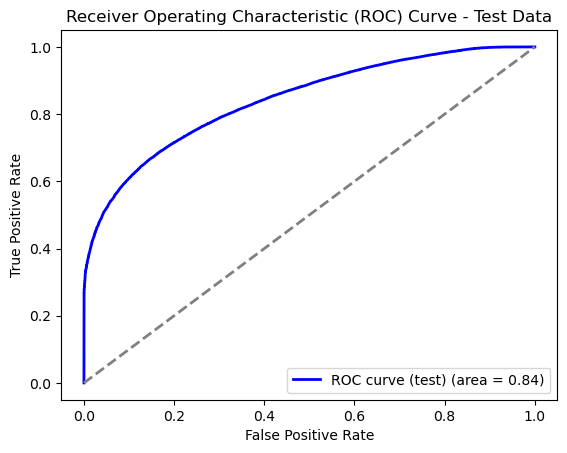

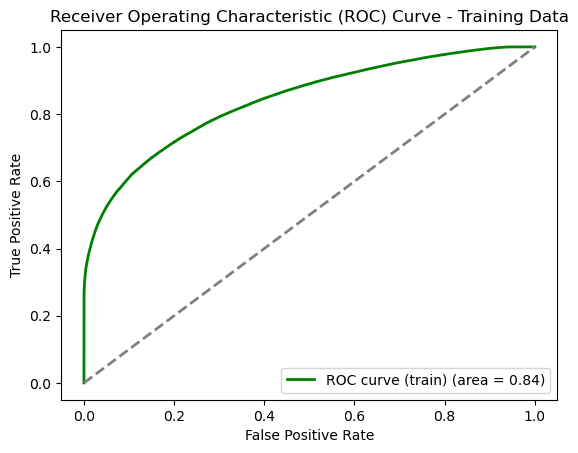

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

model = GradientBoostingClassifier(
    max_depth=4,                   # Control tree depth
    learning_rate=0.03,            # Lower learning rate for gradual learning
    n_estimators=300,              # Higher boosting iterations to compensate for lower learning rate
    subsample=0.8,                 # Random subsampling for better generalization
    random_state=42                # For reproducibility
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    max_depth=3,                   # Control tree depth
    learning_rate=0.02,            # Lower learning rate for gradual learning
    n_estimators=400,              # Higher boosting iterations to compensate for lower learning rate
    subsample=0.6,                 # Random subsampling for better generalization
    random_state=42                # For reproducibility
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [4]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    max_depth=4,                   # Control tree depth
    learning_rate=0.03,            # Lower learning rate for gradual learning
    n_estimators=300,              # Higher boosting iterations to compensate for lower learning rate
    subsample=0.8,                 # Random subsampling for better generalization
    random_state=42                # For reproducibility
)

# Set up stratified k-fold cross-validation (ensuring class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture metrics
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc', 'neg_log_loss'], return_train_score=True)

# Output the results of cross-validation
print("Cross-Validation Results:")
print(f"Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Test ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"Mean Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f}")
print(f"Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Mean Train ROC AUC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"Mean Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f}")

# Now fit the model on the entire training dataset and evaluate it
model.fit(X_train, y_train)

# Predictions and evaluation metrics as before
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")

Cross-Validation Results:
Mean Test Accuracy: 0.7561
Mean Test ROC AUC: 0.8406
Mean Test Log Loss: 0.4654
Mean Train Accuracy: 0.7573
Mean Train ROC AUC: 0.8420
Mean Train Log Loss: 0.4641

Test Accuracy: 0.7535
Test Log Loss: 0.4656
Test ROC AUC: 0.8424
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.61      0.65     33230
           1       0.78      0.84      0.81     55844

    accuracy                           0.75     89074
   macro avg       0.74      0.73      0.73     89074
weighted avg       0.75      0.75      0.75     89074

